## Development of SVR Models

This notebook reproduces Fig. S8

Authors: Johannes Betz and Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [1]:
import numpy as np
import pandas as pd
import glob 
import difflib
import time
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from sklearn import svm 
from sklearn.inspection import permutation_importance
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from scipy.stats import binned_statistic, binned_statistic_2d
from joblib import dump, load
# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

In [3]:
# load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)

# randomly draw indices for 10%, 30%, and 60% of dataset
all_indices = df_idrome[~df_idrome.fasta.duplicated()].sample(frac=1,axis='index',random_state=17).index
inds10 = all_indices[:int(all_indices.size*.1)]
inds30 = all_indices[int(all_indices.size*.1):int(all_indices.size*.4)]
inds60 = all_indices[int(all_indices.size*.4):]

with open('svr_models/inds10.txt', 'w') as outfile:
    outfile.write('\n'.join(inds10))
with open('svr_models/inds30.txt', 'w') as outfile:
    outfile.write('\n'.join(inds30))
with open('svr_models/inds60.txt', 'w') as outfile:
    outfile.write('\n'.join(inds60))

print(all_indices.size-inds10.size-inds30.size-inds60.size)

print(df_idrome.loc[inds10].query('N>500').N.size)
print(df_idrome.loc[inds30].query('N>500').N.size)
print(df_idrome.loc[inds60].query('N>500').N.size)

# input features
features_nu = ['scd','shd','kappa','fcr','mean_lambda']
features_spr = ['scd','shd','mean_lambda']
feature_dict = {'scd':'SCD','shd':'SHD',
                'mean_lambda':r'$\langle \lambda \rangle$',
                'fcr':'FCR','kappa':'$\kappa$'}

0
106
333
688


In [4]:
inds10.size

2795

### Train SVR model to predict $\nu$

#### Grid search of hyperparameters

In [195]:
#eps_range = np.concatenate((np.arange(0,0.0012,0.0002),np.arange(0.002,0.012,0.002),np.arange(0.02,0.12,0.02)))
eps_range = np.arange(0.02,0.03,0.001)
c_range = np.arange(62,70,1)

#write pearson correlations to array
pearsons = np.zeros((len(eps_range),len(c_range)))
for eps_i,eps in enumerate(eps_range):
    for c_i,c in enumerate(c_range):
        X = df_idrome.loc[inds30,features_nu].values
        y = df_idrome.loc[inds30,'nu'].values

        model = svm.SVR(epsilon=eps,C=c)
        model.fit(X,y)

        X_test = df_idrome.loc[inds60,features_nu].values
        y_pred = model.predict(X_test)

        y_sim = df_idrome.loc[inds60,'nu'].values
        
        pearson_corr = pearsonr(y_pred,y_sim)
        pearsons[eps_i][c_i] = pearson_corr[0]
        
eps_i_max, c_i_max = np.where(pearsons==pearsons.max())
opt_eps = eps_range[eps_i_max]
opt_c = c_range[c_i_max]

print('Optimal Hyperparameters')
print('epsilon =',opt_eps,', C =',opt_c)

Optimal Hyperparameters
epsilon = [0.021] , C = [67]


In [196]:
opt_eps = 0.021
opt_c = 67

#### Train SVR model

In [197]:
X = np.array(df_idrome.loc[inds30,features_nu])
y = np.array(df_idrome.loc[inds30,'nu'])
model_nu = svm.SVR(epsilon=opt_eps,C=opt_c,verbose=True)
model_nu.fit(X,y)

[LibSVM]........................................
*............................................................*
optimization finished, #iter = 100104
obj = -972.629875, rho = -0.615109
nSV = 1044, nBSV = 928


SVR(C=67, epsilon=0.021, verbose=True)

### Train SVR model to predict $S_\text{conf}/N$

#### Grid search of hyperparameters

In [224]:
#eps_range = np.concatenate((np.arange(0,0.0012,0.0002),np.arange(0.002,0.012,0.002),np.arange(0.02,0.12,0.02)))
eps_range = np.arange(0.005,0.015,0.001)
c_range = np.arange(170,190,1)

#write pearson correlations to array
pearsons = np.zeros((len(eps_range),len(c_range)))
for eps_i,eps in enumerate(eps_range):
    for c_i,c in enumerate(c_range):
        X = df_idrome.loc[inds30,features_spr].values
        y = df_idrome.loc[inds30,'SPR'].values

        model = svm.SVR(epsilon=eps,C=c)
        model.fit(X,y)

        X_test = df_idrome.loc[inds60,features_spr].values
        y_pred = model.predict(X_test)

        y_sim = df_idrome.loc[inds60,'SPR'].values
        
        pearson_corr = pearsonr(y_pred,y_sim)
        pearsons[eps_i][c_i] = pearson_corr[0]
        
eps_i_max, c_i_max = np.where(pearsons==pearsons.max())
opt_eps = eps_range[eps_i_max]
opt_c = c_range[c_i_max]

print('Optimal Hyperparameters')
print('epsilon =',opt_eps,', C =',opt_c)

Optimal Hyperparameters
epsilon = [0.007] , C = [188]


In [209]:
opt_eps = 0.007
opt_c = 188

#### Train SVR model

In [225]:
X = np.array(df_idrome.loc[inds30,features_spr])
y = np.array(df_idrome.loc[inds30,'SPR'])
model_spr = svm.SVR(epsilon=opt_eps,C=opt_c,verbose=True)
model_spr.fit(X,y)

[LibSVM]..............................................................................................................................................................................
*............................................................................................................................................................*...................*
optimization finished, #iter = 348748
obj = -55249.613670, rho = -10.622393
nSV = 7376, nBSV = 7258


SVR(C=array([188]), epsilon=array([0.007]), verbose=True)

#### Export models using joblib

In [226]:
dump(model_nu, 'svr_models/svr_model_nu.joblib') 
dump(model_spr, 'svr_models/svr_model_SPR.joblib') 

['svr_model/svr_model_SPR.joblib']

#### Load models using joblib

In [3]:
model_nu = load('svr_models/svr_model_nu.joblib') 
model_spr = load('svr_models/svr_model_SPR.joblib') 

#### Calculate $\nu_{\text{SVR}}$ and $S_\text{conf,SVR}/N$ for all sequences

In [238]:
for seq_name in df_idrome.index:
    df_idrome.loc[seq_name,'nu_svr'] = model_nu.predict(df_idrome.loc[seq_name,features_nu].values.reshape(1, -1))
    df_idrome.loc[seq_name,'SPR_svr'] = model_spr.predict(df_idrome.loc[seq_name,features_spr].values.reshape(1, -1))
df_idrome.nu_svr = df_idrome.nu_svr.apply(lambda x: round(x,3))
df_idrome.to_csv('IDRome_DB.csv')

In [239]:
df_idrome_spot = pd.read_csv('IDRome_DB_SPOT.csv',index_col=0)
for seq_name in df_idrome_spot.index:
    df_idrome_spot.loc[seq_name,'nu_svr'] = model_nu.predict(
        df_idrome_spot.loc[seq_name,features_nu].values.reshape(1, -1))
    df_idrome_spot.loc[seq_name,'SPR_svr'] = model_spr.predict(
        df_idrome_spot.loc[seq_name,features_spr].values.reshape(1, -1))
df_idrome_spot.nu_svr = df_idrome_spot.nu_svr.apply(lambda x: round(x,3))
df_idrome_spot.to_csv('IDRome_DB_SPOT.csv')

#### Scaling exponents in validation set

In [4]:
features_nu_60 = df_idrome.loc[inds60,features_nu].values
nu_60 = df_idrome.loc[inds60,'nu'].values
features_spr_60 = df_idrome.loc[inds60,features_spr].values
spr_60 = df_idrome.loc[inds60,'nu'].values

####  Permutation feature importance testing

In [5]:
per_imp_nu = permutation_importance(model_nu,features_nu_60,nu_60)
per_imp_spr = permutation_importance(model_spr,features_spr_60,spr_60)

#### Fig. S8

nu RMSE 0.019445635423673134 MAE 0.011704830053667261
0.8755765742420111 0.8747091314490226 0.01668496156040729
SPR RMSE 0.06282917616876674 MAE 0.04263580646985233
0.9069305667093157 0.9071838536739336 0.009489038233325073
(611,)
0.9288700963126599 0.92891169743726 0.01086174450016648
(611,)
0.876195015656532 0.876694303617578 0.014825650418059715


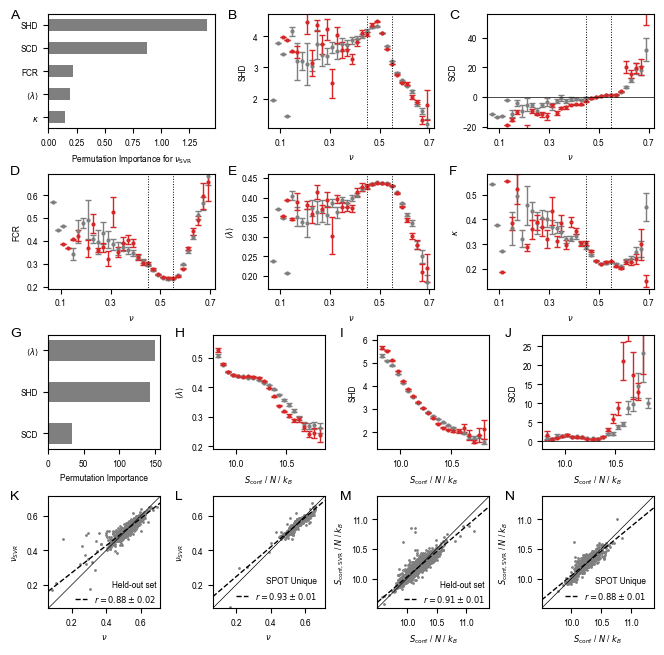

In [9]:
f = plt.figure(figsize=(6.6,6.5))
ax1 = plt.subplot2grid( (4,12), (0,0), rowspan=1, colspan=4 )
ax2 = plt.subplot2grid( (4,12), (0,4), rowspan=1, colspan=4 )
ax3 = plt.subplot2grid( (4,12), (0,8), rowspan=1, colspan=4 )
ax4 = plt.subplot2grid( (4,12), (1,0), rowspan=1, colspan=4 )
ax5 = plt.subplot2grid( (4,12), (1,4), rowspan=1, colspan=4 )
ax6 = plt.subplot2grid( (4,12), (1,8), rowspan=1, colspan=4 )
ax7 = plt.subplot2grid( (4,12), (2,0), rowspan=1, colspan=3 )
ax8 = plt.subplot2grid( (4,12), (2,3), rowspan=1, colspan=3 )
ax9 = plt.subplot2grid( (4,12), (2,6), rowspan=1, colspan=3 )
ax10 = plt.subplot2grid( (4,12), (2,9), rowspan=1, colspan=3 )
ax11 = plt.subplot2grid( (4,12), (3,0), rowspan=1, colspan=3 )
ax12 = plt.subplot2grid( (4,12), (3,3), rowspan=1, colspan=3 )
ax13 = plt.subplot2grid( (4,12), (3,6), rowspan=1, colspan=3 )
ax14 = plt.subplot2grid( (4,12), (3,9), rowspan=1, colspan=3 )
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14]

features_nu = np.array(features_nu)
sorted_idx = per_imp_nu.importances_mean.argsort()
axes[0].barh(features_nu[sorted_idx],per_imp_nu.importances_mean[sorted_idx],color='tab:gray',height=.5)
feature_labels = [feature_dict[f] for f in features_nu[sorted_idx]]
axes[0].set_yticks(range(5))
axes[0].set_yticklabels(feature_labels)
axes[0].set_xlabel('Permutation Importance for $\\nu_\mathrm{SVR}$')

bins = np.arange(0, .701, .02)
x = bins[:-1]+.01

for ax,feature,label in zip(axes[1:6],features_nu[sorted_idx][::-1],feature_labels[::-1]):

    average = binned_statistic(df_idrome.nu,df_idrome[feature],bins=bins)[0]
    standard_error = binned_statistic(df_idrome.nu,df_idrome[feature],statistic=se,
                                     bins=bins)[0]

    ax.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,label=label,color='tab:gray')
    
    average = binned_statistic(df_idrome.nu_svr,df_idrome[feature],bins=bins)[0]
    standard_error = binned_statistic(df_idrome.nu_svr,df_idrome[feature],statistic=se,
                                     bins=bins)[0]

    ax.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,label=label,color='tab:red')

    ax.set_ylabel(label)
    ymin = np.nanmin(average)
    ymin = ymin*1.3 if ymin <0 else ymin*.8
    ymax = np.nanmax(average)*1.05
    ax.vlines([.45,.55],ymin=-40,ymax=80,color='k',ls=':',lw=.7)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(.05,.72)
    ax.set_xticks([.1,.3,.5,.7])
    ax.set_xlabel('$\\nu$')
    
###############
    
features_spr = np.array(features_spr)
sorted_idx = per_imp_spr.importances_mean.argsort()
axes[6].barh(features_spr[sorted_idx],per_imp_spr.importances_mean[sorted_idx],color='tab:gray',height=.5)
feature_labels = [feature_dict[f] for f in features_spr[sorted_idx]]
axes[6].set_yticks(range(3))
axes[6].set_yticklabels(feature_labels)
axes[6].set_xlabel('Permutation Importance')

bin_width = .05
bins = np.arange(9.8, 10.9, bin_width)
x = bins[:-1]+bin_width/2

for ax,feature,label in zip(axes[7:10],features_spr[sorted_idx][::-1],feature_labels[::-1]):
    
    average = binned_statistic(df_idrome.SPR,df_idrome[feature],bins=bins)[0]
    standard_error = binned_statistic(df_idrome.SPR,df_idrome[feature],statistic=se,
                                     bins=bins)[0]

    ax.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,label=label,color='tab:gray')
    
    average = binned_statistic(df_idrome.SPR_svr,df_idrome[feature],bins=bins)[0]
    standard_error = binned_statistic(df_idrome.SPR_svr,df_idrome[feature],statistic=se,
                                     bins=bins)[0]

    ax.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,label=label,color='tab:red')

    ax.set_ylabel(label)
    ymin = np.nanmin(average)
    ymin = ymin*1.3 if ymin <0 else ymin*.8
    ymax = np.nanmax(average)*1.1
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')

axes[2].axhline(0,lw=.5,color='k')
axes[2].set_ylim(-21,56)
axes[9].axhline(0,lw=.5,color='k')
axes[9].set_ylim(-2,28)

##################

df_idrome_spot = pd.read_csv('IDRome_DB_SPOT.csv',index_col=0).dropna()

# test against held-out set

for ax,feature in zip([ax11,ax13],['nu','SPR']):
    
    df_idrome_10 = df_idrome.loc[inds10]
    test_10 = df_idrome.loc[inds10,feature]
    test_10_svr = df_idrome.loc[inds10,feature+'_svr']

    rmse = np.sqrt(np.mean(np.power(test_10-test_10_svr,2)))
    print(feature,'RMSE',rmse,'MAE',np.abs(test_10-test_10_svr).mean())

    pr = pearsonr(test_10,test_10_svr)[0]

    bootstrap_nu = []
    indices = np.arange(test_10.size)
    for _ in range(1000):
        picked = random.choices(indices,k=indices.size)
        bootstrap_nu.append(pearsonr(test_10[picked],test_10_svr[picked])[0])
    pr_mean = np.mean(bootstrap_nu)
    pr_std = np.std(bootstrap_nu)
    print(pr,pr_mean,pr_std)

    ax.plot(test_10,test_10_svr,ms=1,marker='o',lw=0,color='tab:gray')
    x = np.linspace(df_idrome[feature].min(),df_idrome[feature].max(),100)
    ax.plot(x,x,lw=.5,zorder=4,color='k')
    popt,_ = curve_fit(lambda x,a,b : a*x+b,test_10,test_10_svr)
    ax.plot(x,popt[0]*x+popt[1],ls='--',lw=1,label='$r={:.2f} \pm {:.2f}$'.format(
        pr,pr_std),
        zorder=4,color='k')
    ax.set_aspect('equal')
    ax.set_xlim(x.min(),x.max())
    ax.set_ylim(x.min(),x.max())
    leg = ax.legend(frameon=False,loc='lower right',handlelength=1.5,
                    title='Held-out set',borderpad=0)
    leg._legend_box.align = 'right'
    
# test against SPOT-based IDRs for UniProt IDs not in pLDDT-based set
    
for ax,feature in zip([ax12,ax14],['nu','SPR']):
    
    spot_unique = pd.read_csv('md_simulations/data/conf_prop_spot_unique.csv.gz',index_col=0).index
    test_spot = df_idrome_spot.loc[spot_unique,feature]
    test_spot_svr = df_idrome_spot.loc[spot_unique,feature+'_svr']

    print(test_spot.shape)

    pr = pearsonr(test_spot,test_spot_svr)[0]

    bootstrap_nu = []
    indices = np.arange(test_spot.size)
    for _ in range(1000):
        picked = random.choices(indices,k=indices.size)
        bootstrap_nu.append(pearsonr(test_spot[picked],test_spot_svr[picked])[0])
    pr_mean = np.mean(bootstrap_nu)
    pr_std = np.std(bootstrap_nu)
    print(pr,pr_mean,pr_std)

    ax.plot(test_spot,test_spot_svr,ms=1,marker='o',lw=0,color='tab:gray')
    x = np.linspace(df_idrome[feature].min(),df_idrome[feature].max(),100)
    ax.plot(x,x,lw=.5,zorder=4,color='k')
    popt,_ = curve_fit(lambda x,a,b : a*x+b,test_spot,test_spot_svr)
    ax.plot(x,popt[0]*x+popt[1],ls='--',lw=1,label='$r={:.2f} \pm {:.2f}$'.format(
        pr,pr_std),zorder=4,color='k')

    ax.set_aspect('equal')
    ax.set_xlim(x.min(),x.max())
    ax.set_ylim(x.min(),x.max())
    leg = ax.legend(frameon=False,loc='lower right',handlelength=1.5,title='SPOT Unique')
    leg._legend_box.align = 'right'

for ax in [ax11,ax12]:
    ax.set_xlabel('$\\nu$')
    ax.set_ylabel('$\\nu_{SVR}$')
for ax in [ax13,ax14]:
    ax.set_xlabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')
    ax.set_ylabel(r'$S_{\mathrm{conf},\mathrm{SVR}}$ / $N$ / $k_B$')
    
f.text(0.01, .98, 'A', fontsize=10)
f.text(0.34, .98, 'B', fontsize=10)
f.text(0.675, .98, 'C', fontsize=10)
f.text(0.01, .74, 'D', fontsize=10)
f.text(0.34, .74, 'E', fontsize=10)
f.text(0.675, .74, 'F', fontsize=10)

f.text(0.01, .49, 'G', fontsize=10)
f.text(0.26, .49, 'H', fontsize=10)
f.text(0.51, .49, 'I', fontsize=10)
f.text(0.76, .49, 'J', fontsize=10)

f.text(0.01, .24, 'K', fontsize=10)
f.text(0.26, .24, 'L', fontsize=10)
f.text(0.51, .24, 'M', fontsize=10)
f.text(0.76, .24, 'N', fontsize=10)
    
plt.tight_layout()
plt.savefig('figs/figS8.pdf',dpi=300)
plt.show()